In [20]:
from utils import *
warnings.filterwarnings('ignore')
%matplotlib inline


In [21]:
fd_collection = getCollection("team_5_mwdb_phase_2", "fd_collection")


In [22]:
class ImageGraph:
    """
    Construct image-similarity graph and apply personalized pagerank algorithm to get PPR scores and find relevant images
    """

    def __init__(self, fd_collection, verbose=False):
        self.fd_collection = fd_collection
        self.similarity_graph = None
        self.verbose = verbose

    def create_similarity_graph(
        self, n, feature_model, semantic_data=None, dim_reduction_method=None
    ):
        self.n = n
        import glob

        if semantic_data is None:
            file_prefix = f"image_sim-{feature_model}-*.json"
            if len(glob.glob(file_prefix)) > 0:
                matrix_data = json.load(open(glob.glob(file_prefix)[0]))
                image_sim_matrix = matrix_data["sim-matrix"]
                if self.verbose:
                    print("Using image-image similarity matrix from semantic data")
            else:
                # Similarity graph from feature models
                image_sim_matrix = find_image_image_similarity(
                    fd_collection, feature_model
                )
                if self.verbose:
                    print("Image-image similarity matrix constructed from", feature_model)
        else:
            # Similarity graph from image-semantic latent space
            image_semantic = semantic_data["image-semantic"]
            # SVD, CP
            if "semantics-core" in semantic_data:
                semantics_core = np.array(semantic_data["semantics-core"])
                if len(semantics_core.shape) == 1:
                    semantics_core = np.diag(semantics_core)
                image_semantic = np.matmul(image_semantic, semantics_core)

            image_sim_matrix = np.zeros((NUM_IMAGES, NUM_IMAGES))
            # Calculate half and fill the other
            for i in range(NUM_IMAGES):
                for j in range(i + 1, NUM_IMAGES):
                    # Note: lower the value, lower the distance => higher the similarity
                    distance_measure = (
                        kl_divergence_measure
                        if dim_reduction_method == "lda"
                        else euclidean_distance_measure
                    )
                    image_sim_matrix[j][i] = distance_measure(
                        np.array(image_semantic[i]),
                        np.array(image_semantic[j]),
                    )
                    image_sim_matrix[i][j] = image_sim_matrix[j][i]
            if self.verbose:
                print(
                    "Image-image similarity matrix constructed from given image-semantic"
                )

        # Create an unweighted directed similarity graph, with no self-loops
        self.similarity_graph = []
        for i in range(len(image_sim_matrix)):
            # distances should be small, so sort in ascending order
            similar_image_ids = np.argsort(image_sim_matrix[i])[
                1 : n + 1
            ]  # exclude self
            self.similarity_graph.extend(
                [(i * 2, j * 2) for j in similar_image_ids]
            )  # i*2 cuz even IDs
        if self.verbose:
            print("Similarity graph created")

    def personalized_pagerank(
        self, label, m, damping_factor=0.85, max_iter=1000, tol=1e-6
    ):
        if self.similarity_graph is None:
            raise ValueError(
                "Similarity graph not created. Call create_similarity_graph() first."
            )

        label_indices = [
            img["image_id"] for img in self.fd_collection.find({"true_label": label})
        ]  # IDs of images with the given label
        num_label_nodes = len(label_indices)

        pr_scores = np.ones(NUM_IMAGES) / NUM_IMAGES  # Initialize PageRank scores
        if self.verbose:
            print("Initialized pagerank scores")

        for _iter in range(max_iter):
            prev_scores = np.copy(pr_scores)

            # for every edge
            for (i, j) in self.similarity_graph:
                # add neighbor's score
                pr_scores[int(i / 2)] += damping_factor * pr_scores[int(j / 2)] / self.n

            # extra teleport prob for label nodes only
            for label_node in label_indices:
                pr_scores[int(label_node / 2)] += (1 - damping_factor) / num_label_nodes

            # normalize
            pr_scores /= sum(pr_scores)

            # check for convergence
            conv_tol = np.sum(np.abs(prev_scores - pr_scores))
            if self.verbose:
                print(f"Iter {_iter}, conv_tol={conv_tol}")
            if conv_tol < tol:
                if self.verbose:
                    print(f"Converged")
                break

        # Select top m images based on PageRank scores
        top_m_indices = np.argsort(pr_scores)[::-1][
            :m
        ]  # sort indices, reverse and take top m
        return top_m_indices * 2  # again, even IDs


In [30]:
n = int(input("Enter value of n (no. of edges for each image in similarity graph): "))
if n < 1:
    raise ValueError("n should be a positive integer")

l = int(input("Enter target label l:"))
if l < 0 or l > 100:
    raise ValueError("l should be in range[0,100]")

m = int(input("Enter value of m (no. of significant images relative to given label): "))
if m < 1:
    raise ValueError("m should be a positive integer")

given_ls = int(
    (input("Enter 0 to select a feature model, 1 to select a latent space: "))
)

selected_feature_model = valid_feature_models[
    str(input("Enter feature model - one of " + str(list(valid_feature_models.keys()))))
]

if given_ls:
    selected_latent_space = valid_latent_spaces[
        str(
            input(
                "Enter latent space - one of " + str(list(valid_latent_spaces.keys()))
            )
        )
    ]

    k = int(input("Enter value of k (no. of latent semantics): "))
    if k < 1:
        raise ValueError("k should be a positive integer")

    if selected_latent_space != "cp":
        selected_dim_reduction_method = str(
            input(
                "Enter dimensionality reduction method - one of "
                + str(list(valid_dim_reduction_methods.keys()))
            )
        )

    # Loading latent semantics
    match selected_latent_space:
        # LS1
        case "":
            file_prefix = (
                f"{selected_feature_model}-{selected_dim_reduction_method}-{k}"
            )
            file_name = file_prefix + "-semantics.json"
            model_name = file_prefix + "-model.joblib"
            if os.path.exists(file_name):
                data = json.load(open(file_name))
                print(file_name + " loaded")
            else:
                raise Exception(file_name + " does not exist")
            # LDA model
            if selected_dim_reduction_method == "lda":
                if os.path.exists(model_name):
                    data_model = load(model_name)
                    print(model_name + " loaded")
                else:
                    raise Exception(model_name + " does not exist")
        # LS2
        case "cp":
            file_name = f"{selected_feature_model}-cp-{k}-semantics.json"
            if os.path.exists(file_name):
                data = json.load(open(file_name))
                print(file_name + " loaded")
            else:
                raise Exception(file_name + " does not exist")
        # LS3, LS4
        case _:
            file_name = f"{selected_latent_space}-{selected_feature_model}-{selected_dim_reduction_method}-{k}-semantics.json"
            if os.path.exists(file_name):
                data = json.load(open(file_name))
                print(file_name + " loaded")
            else:
                raise Exception(file_name + " does not exist")


In [31]:
if not given_ls:
    img_graph = ImageGraph(fd_collection, True)
    img_graph.create_similarity_graph(n, selected_feature_model)
    result = img_graph.personalized_pagerank(l, m)
else:
    img_graph = ImageGraph(fd_collection, True)
    img_graph.create_similarity_graph(
        n, selected_feature_model, data, selected_dim_reduction_method
    )
    result = img_graph.personalized_pagerank(l, m)


Using image-image similarity matrix from semantic data
Similarity graph created
Initialized pagerank scores
Iter 0, conv_tol=0.18724034691212726
Iter 1, conv_tol=0.09529123133690318
Iter 2, conv_tol=0.05891033461484138
Iter 3, conv_tol=0.041659168986629046
Iter 4, conv_tol=0.03163619485064377
Iter 5, conv_tol=0.02525397691483519
Iter 6, conv_tol=0.021053599233057718
Iter 7, conv_tol=0.018240092181992636
Iter 8, conv_tol=0.016331971318731653
Iter 9, conv_tol=0.01501549841296805
Iter 10, conv_tol=0.014093894901999637
Iter 11, conv_tol=0.013429273907878113
Iter 12, conv_tol=0.012937585772259381
Iter 13, conv_tol=0.012559460008643965
Iter 14, conv_tol=0.012253669889733369
Iter 15, conv_tol=0.011995449161964874
Iter 16, conv_tol=0.011769831354200174
Iter 17, conv_tol=0.011567179432484344
Iter 18, conv_tol=0.011381190579776186
Iter 19, conv_tol=0.011207446601161287
Iter 20, conv_tol=0.011043225573264747
Iter 21, conv_tol=0.010885793708699888
Iter 22, conv_tol=0.010733408188048766
Iter 23, co

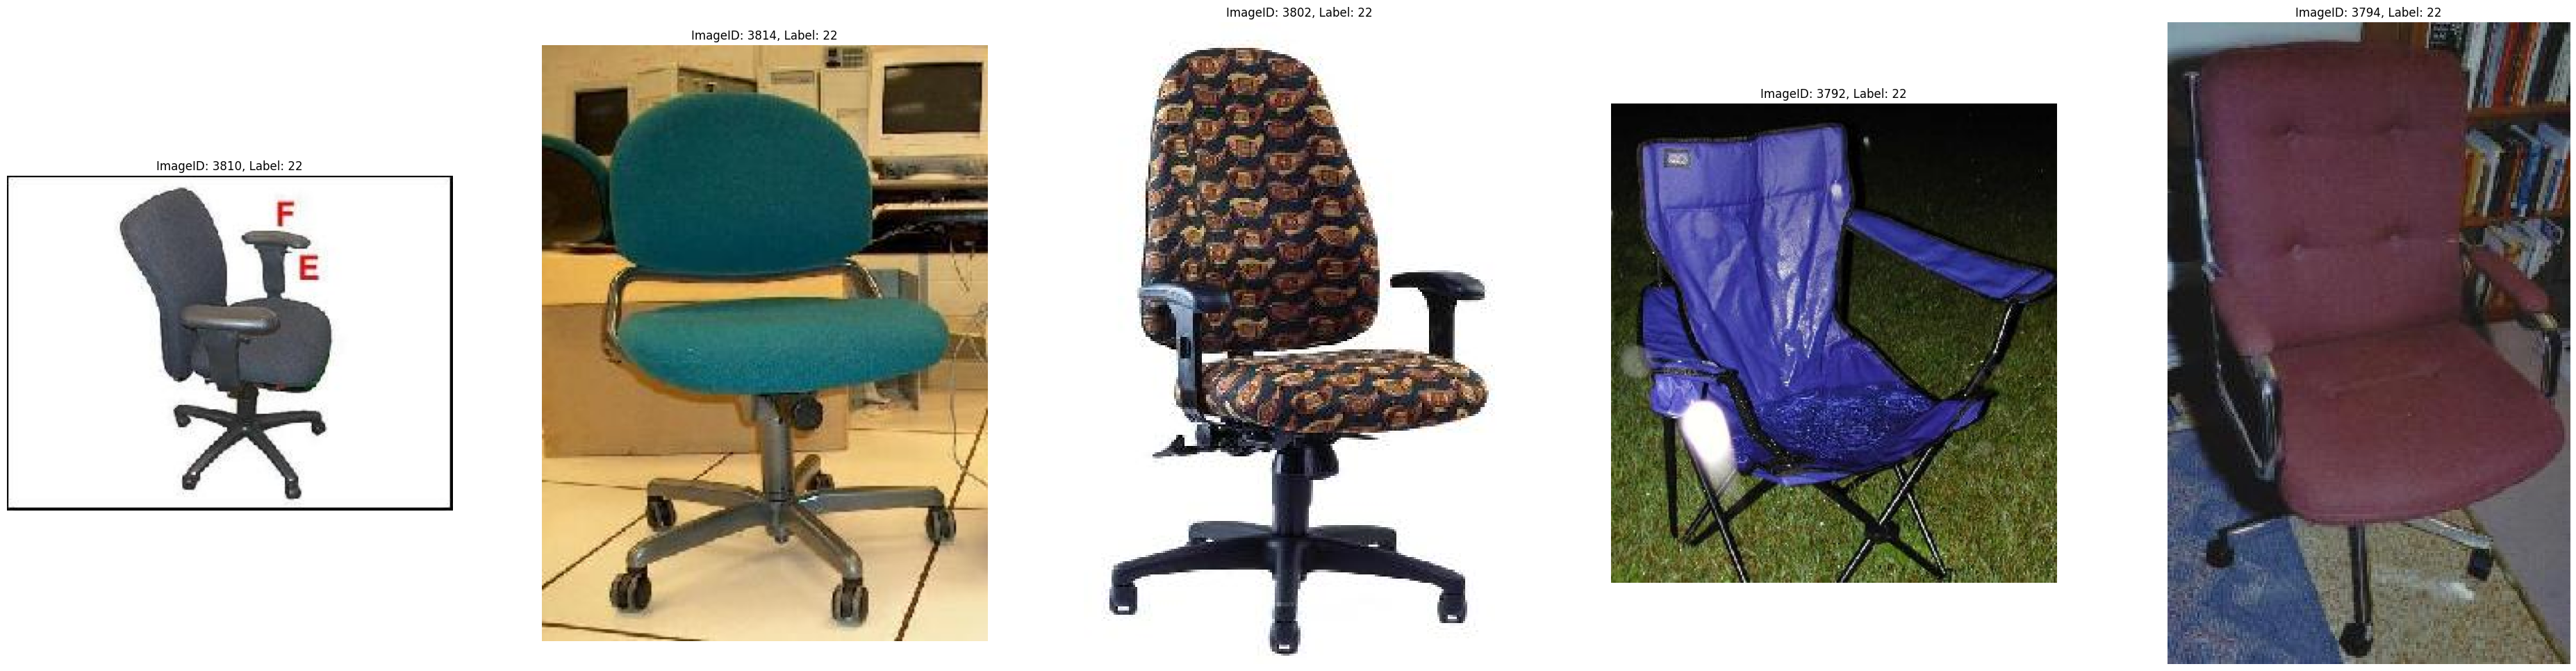

In [32]:
fig, axs = plt.subplots(1, m, figsize=(48, 12))
for idx, img_id in enumerate(result):
    cur_img, cur_label = dataset[img_id]
    axs[idx].imshow(transforms.ToPILImage()(cur_img))
    axs[idx].set_title("ImageID: {}, Label: {}".format(img_id, cur_label))
    axs[idx].axis("off")
plt.show()
